In [0]:
import pandas as pd
import random
import io
import ast
import numpy as np
import os
import re
import string
import pickle
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tnrange
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [0]:
random.seed(13)
np.random.seed(13)

### Loading texts, split on train, val and test


In [3]:
!wget https://www.dropbox.com/s/n8nfxxh5azocrrm/train_LASER.csv?dl=0
!wget https://www.dropbox.com/s/je9am5c77ytfcaf/test_LASER.csv?dl=0 

--2020-05-02 10:50:19--  https://www.dropbox.com/s/n8nfxxh5azocrrm/train_LASER.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/n8nfxxh5azocrrm/train_LASER.csv [following]
--2020-05-02 10:50:19--  https://www.dropbox.com/s/raw/n8nfxxh5azocrrm/train_LASER.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc72de2fc62b14c0bd6494894e9f.dl.dropboxusercontent.com/cd/0/inline/A28fJRSnH4CeYIEHZ7ES0cO_0nfQL043Fgfvwkv0ZCq4UMsBRxcQ2Wc8hHs66gr5vViXNij82u1sZqiag5_CEkV_KS2vZ8DaNp8cNgS9kjvQs6wf9kmNaO9u9Ttbphujuyk/file# [following]
--2020-05-02 10:50:19--  https://uc72de2fc62b14c0bd6494894e9f.dl.dropboxusercontent.com/cd/0/inline/A28fJRSnH4CeYIEHZ7ES0cO_0nfQL043Fgfvwkv0ZCq4UMsBRxcQ2Wc8hHs66gr5vViXNij82u1sZqiag5_CEkV_KS2vZ8DaNp8c

In [4]:
df_train = pd.read_csv("train_LASER.csv?dl=0").dropna()

train_texts = list(df_train['abstracts'])
train_labels = list(df_train['labels'])
len(train_labels)


80948

In [5]:
df_test = pd.read_csv("test_LASER.csv?dl=0").dropna()

test_texts = list(df_test['lemm_abstracts'])
test_labels = list(df_test['labels'])
len(test_labels)

10150

In [6]:
test_texts[1000]

'использование биотехнология, медицинская микробиология и может быть использовано в производстве эубиотических препаратов и бифидосодержащих продуктов питания. сущность изобретения питательная среда в качестве основы содержит молочную сыворотку, осветленную последовательной обработкой обезжиренного молока кислотой и щелочью, и дрожжевой автолизат сухой или жидкий и дополнительно натрий фосфорнокислый однозамещенный двуводный, аммоний хлористый и магний сернокислый семиводный, при следующем соотношении компонентов мас. молочная сыворотка осветленная , , , лактоза , , , дрожжевой автолизат сухой или жидкий , , и , , , d,l цистеин , , , nah po • h o , , , nh cl , , , mgso • h o , , , агар агар , , , вода остальное, ph , , .'

In [0]:
#разбиваем на train и val английские тексты
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, \
                                                          test_size=0.15, shuffle = True, random_state=42, stratify=train_labels)

In [8]:
print(len(train_labels))
print(len(val_labels))

68805
12143


In [9]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_val = label_encoder.transform(val_labels)
y_test = label_encoder.transform(test_labels)

y_train[:10]

array([ 58, 199, 218,   7, 196, 115,  69,   1,  13,  23])

### Cleaning

In [0]:
def cleaning(text):
    clean_txt = []
    for sentence in text.split('.'): 
        sentence = re.sub(r'[•⋅−,]', ' ', sentence)
        sent = re.sub(r'( )+', ' ', sentence)
     #   if len(sent.split()) > 2 and sent != 'ф лы, ил':
        if len(sent.split()) > 2 and 'ф лы' not in sent:
             clean_txt.append(sent.strip())
    return ' '.join(clean_txt) 

In [11]:
test_texts = [cleaning(text) for text in tqdm(test_texts)]
val_texts = [cleaning(text) for text in tqdm(val_texts)]
train_texts = [cleaning(text) for text in tqdm(train_texts)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
test_texts[10:20]

['замок относится к замкам предназначенным для ящиков чемоданов футляров обтекателей и других изделий и позволяет повысить его надежность он состоит из крючка и собственно замка имеющего основание и соединенный с ним осью рычаг серьгу связанную с рычагом и входящую в зацепление с крючком в замке предусмотрен несъемный фиксатор размещенный на рычаге имеющий подпружиненный штырь входящий в отверстие основания для исключения разъединения серьги и крючка в случае непроизвольного срыва фиксации рычага относительно основания и прихода тем самым рычага в положение открытия замка крючок снабжен упругой пластиной закрывающей его и предотвращающей выход серьги из крючка для обеспечения удобства вывода серьги из зацепления с крючком при открытии замка упругая пластина снабжена площадками выходящими из зоны крючка для отжатия пластины пальцами от носка крючка тем самым открытия крючка для вывода серьги',
 'изобретение относится к вставной муфте для электрических шланговых кабелей в частности для п

### Lemmatization

In [0]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /bin

In [0]:
from pymystem3 import Mystem
m = Mystem()


In [0]:
test_lemm = [''.join(m.lemmatize(text)).strip() for text in tqdm(test_texts)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [0]:
print('До лемматизации: ', test_texts[1])
print('После лемматизации: ', test_lemm[1])

До лемматизации:  изобретение относится к области радиосвязи техническим результатом является повышение эффективности использования радиоресурсов нисходящей линии связи упомянутый технический результат достигается тем что сетевое устройство радиодоступа осуществляет связь с мобильной станцией с использованием выделенного канала восходящей линии связи общего канала данных нисходящей линии связи и сигнального канала управления нисходящей линии связи устранение необходимости в ненужной передаче восходящего гранта временного опережения в восходящей линии связи или c rnti cell specific radio network temporal identifier делает возможной реализацию мобильной станции сетевого устройства радиодоступа и системы мобильной связи в соответствии с настоящим изобретением
После лемматизации:  изобретение относиться к область радиосвязь технический результат являться повышение эффективность использование радиоресурсы нисходящий линия связь упоминать технический результат достигаться то что сетевой устр

In [0]:
# https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/

import spacy
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])
sentence = "The striped bats are hanging on their feet for best"
# Parse the sentence using the loaded 'en' model object `nlp`
doc = nlp(sentence)
# Extract the lemma for each token and join
#" ".join([token.lemma_ for token in doc])
" ".join([w.lemma_ if w.lemma_ !='-PRON-' else w.text for w in doc])
#> 'the strip bat be hang on -PRON- foot for good'

'the stripe bat be hang on their foot for good'

In [0]:
train_lemm = []
for text in tqdm(train_texts):
    train_lemm.append(" ".join([w.lemma_ if w.lemma_ !='-PRON-' else w.text for w in nlp(text)]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [0]:
train_lemm[0]

'a combine vehicle remote access tire monitoring and vehicle immobilization system and method include a tire monitor for monitor a tire parameter the monitor include a transmitter for transmit a radio frequency tire datum signal a vehicle access transmitter for transmit a radio frequency vehicle access signal and a vehicle activation transponder for receive an interrogation signal and transmit a vehicle activation signal for use in vehicle immobilization the system and method further include a control module have a receiver and a controller for receiving and process the tire data vehicle access and vehicle activation signal and generate a display signal to display the information represent by the tire datum signal a vehicle access control signal to perform the vehicle access function and a vehicle immobilization control signal to immobilize the vehicle if the controller fail to authenticate the vehicle activation signal'

In [0]:
val_lemm = []
for text in tqdm(val_texts):
    val_lemm.append(" ".join([w.lemma_ if w.lemma_ !='-PRON-' else w.text for w in nlp(text)]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


### Lengths

In [12]:
def compute_lens(texts):
    lens = [len(text.split()) for text in texts]
    return lens

train_lens = compute_lens(train_texts)
val_lens = compute_lens(val_texts)
test_lens = compute_lens(test_texts)
train_lens[:10]

[142, 194, 152, 77, 98, 100, 149, 206, 96, 158]

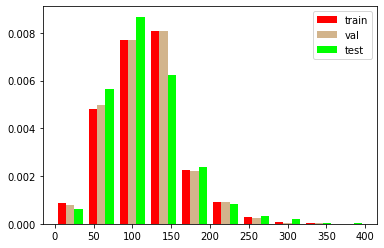

In [22]:
n_bins = 10

colors = ['red', 'tan', 'lime']

# Make a multiple-histogram of data-sets with different length.

plt.hist([train_lens, val_lens, test_lens], n_bins, histtype='bar', color=colors, density=True, range=(0, 400))
#ax3.set_title('different sample sizes')
plt.legend(['train', 'val', 'test'])
plt.savefig('Lengths distribution.png')
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


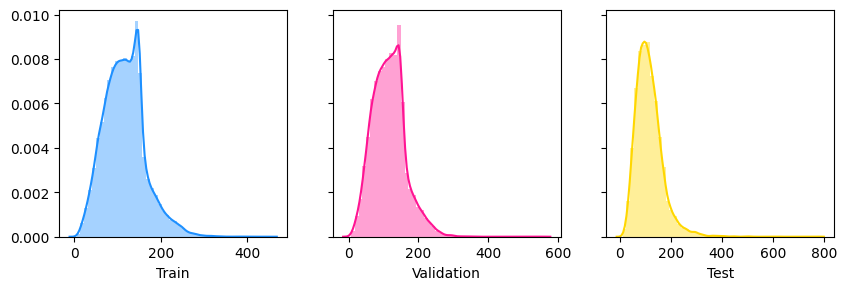

In [19]:
# plot
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True, dpi=100)
sns.distplot(train_lens , color="dodgerblue", ax=axes[0], axlabel='Train')
sns.distplot(val_lens , color="deeppink", ax=axes[1], axlabel='Validation')
sns.distplot(test_lens , color="gold", ax=axes[2], axlabel='Test')
#plt.suptitle('Probability Histogram of Datasets lengths', y=1.05, size=12)
#plt.xlim(50,75);
plt.savefig('Lengths distribution2.png')

### Vocabulary sizes

In [0]:
for lst, name in zip([train_lemm, val_lemm, test_lemm], ['train', 'val', 'test']):
    vectorizer = CountVectorizer()
    vectorizer.fit(lst)
    print('Length of ' + str(name) + ' vocabulary: ', len(vectorizer.vocabulary_))

Length of train vocabulary:  41442
Length of val vocabulary:  19018
Length of test vocabulary:  28970


In [0]:
train_topics = [[] for i in range(225)]
for i, text in tqdm(enumerate(train_lemm)):
    train_topics[y_train[i]].append(len(set(text.split())))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [0]:
mean_vocab_topic_lens =  [np.median(num) for num in train_topics]  #медианы числа уникальных слов в подклассе

In [0]:
np.argsort(mean_vocab_topic_lens)

array([ 83,  85,  20,   1,   4,  92,  89,  96,  95,  84,  82, 209, 224,
        94,  87, 210, 188, 169, 170, 196, 190, 218, 189, 195, 174,  53,
       221,   6, 205,  90, 220, 158, 120,  86,  88,  54,  78, 107, 178,
       104, 192, 175, 185,  32, 204, 212, 213,  21, 211,  19, 149, 207,
        45, 222,  64, 186,  27,  77,  91, 141,  73, 216, 140, 125,  61,
        44,  46, 123, 198, 197,  52, 202,  62, 215,  59, 176, 144, 172,
       157, 173, 168, 171, 127, 122, 163, 136, 128, 147, 110, 177, 166,
       108, 182, 159, 153,  47, 193,   7, 208,  57,  56,  14, 217,  26,
       214,  10,  15,  55, 154, 167, 132, 203,  41, 165, 134, 160, 162,
       161,  30, 142, 143,  28, 146,  18,  35,  42,   8,  72,  16, 184,
       101, 179, 103, 187, 106,  79, 126,  68, 219,  66,  65, 116, 117,
        60,  50, 199, 194, 164, 191, 206, 180, 181, 156, 200, 112, 105,
        97,  24,  98,  99,  71, 109,  69, 223, 113,  22,  36, 118,  58,
        63,  25, 129, 130,  12, 133, 135,  43,  11,  37, 139,   

In [0]:
label_encoder.inverse_transform([33])

array(['B04B'], dtype='<U4')

In [0]:
label_encoder.inverse_transform([83])

array(['C07D'], dtype='<U4')

In [0]:
#ничего особо интересного тут выявить не удалось
print(np.min(mean_vocab_topic_lens))     
print(np.max(mean_vocab_topic_lens))

39.0
58.5


### Keywords topics

In [0]:
def matrix_for_features(texts, labels):
    '''
    функция для поиска ключевых слов для каждого класса
    подаются тексты и метки
    возвращается матрица tfidf, фичи и веса (сейчас это idf для каждого слова)
    '''
    text_classes = ['' for i in range(len(set(labels)))]
    for i, text in enumerate(texts):
      #  text_classes[labels[i]] += (' '.join(list(set(text.split()))) + ' ')
        text_classes[labels[i]] += (text + ' ')
    vectorizer = TfidfVectorizer(min_df=2, max_df=0.8)
    X = vectorizer.fit_transform(text_classes)
    feature_names = np.array(vectorizer.get_feature_names())
    return X, feature_names

In [0]:
X_russian, features_russian = matrix_for_features(test_lemm, y_test)
X_english, features_english = matrix_for_features(train_lemm, y_train)

In [0]:
with open('features_classes_plus_weights.txt', 'w', encoding='utf-8') as of:
    for i in range(225):
        tfidf_rus = X_russian[i].toarray()[0]
        tfidf_eng = X_english[i].toarray()[0]
        indices_ru = np.argsort(tfidf_rus)[::-1]
        indices_eng = np.argsort(tfidf_eng)[::-1]
        for idx in indices_ru[:10]:
            of.write(features_russian[idx] + '|' + str(tfidf_rus[idx]) + ' ') #tfidf_rus
        of.write('|')
        for idx in indices_eng[:10]:
            of.write(features_english[idx] + '|' + str(tfidf_eng[idx]) + ' ')  #tfidf_eng      
        of.write('\t' + label_encoder.classes_[i] + '\n')
        of.write(str(i) +'\n')
        of.write('===========================' + '\n'*2)
    of.close()

In [0]:
with open('features_classes.txt', 'w', encoding='utf-8') as of:
    for i in range(225):
        tfidf_rus = X_russian[i].toarray()[0]
        tfidf_eng = X_english[i].toarray()[0]
        indices_ru = np.argsort(tfidf_rus)[::-1]
        indices_eng = np.argsort(tfidf_eng)[::-1]
        for idx in indices_ru[:10]:
            of.write(features_russian[idx] + '|') #tfidf_rus
        of.write('|')
        for idx in indices_eng[:10]:
            of.write(features_english[idx] + '|')  #tfidf_eng      
        of.write('\t' + label_encoder.classes_[i] + '\n')
        of.write(str(i) +'\n')
        of.write('===========================' + '\n'*2)
    of.close()